In [9]:
import tensorflow as tf
from glob import glob
import numpy as np
import logging
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import h5py
import pickle
from sklearn.model_selection import KFold
from kerastuner import HyperModel, RandomSearch
import os
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import json
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle


from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, UpSampling2D, Reshape,  Dropout, Conv2DTranspose, Add, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model


In [10]:
import umap

In [11]:
SEED = 42
VALIDATION_SPLIT= 0.3
TEST_SPLIT = 0.1

In [12]:
# Setup logger
logging.basicConfig(level=logging.INFO)
_logger = logging.getLogger(__name__)

In [13]:
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [128, 128])  # Resize images to 128x128
    return img / 255.0  # Normalize the images to [0, 1]

In [21]:
""" 

def load_occupancy_image_paths(data_folder):
    # List images
    occupied = glob(os.path.join(data_folder, "[!empty]*/*.png"))
    empty = glob(os.path.join(data_folder, "empty/*.png"))

    # Downsample the majority class
    rng = np.random.default_rng(seed=SEED)
    rng.shuffle(empty)
    empty = empty[:len(occupied)]

    print(f"Occupied samples: {len(occupied)}")
    print(f"Empty samples: {len(empty)}")

    # Combine paths
    paths = np.array(occupied + empty)
    return paths """


In [14]:
def load_occupancy_image_paths(data_folder):
    # List all image paths for non-empty classes and their labels
    occupied_paths = []
    occupied_labels = []
    for label in os.listdir(data_folder):
        if label != "empty":
            label_paths = glob(os.path.join(data_folder, label, "*.png"))
            occupied_paths.extend(label_paths)
            occupied_labels.extend([label] * len(label_paths))

    # List image paths for the empty class
    empty_paths = glob(os.path.join(data_folder, "empty/*.png"))
    empty_labels = ["empty"] * len(empty_paths)

    # Downsample the empty class
    rng = np.random.default_rng(seed=SEED)
    rng.shuffle(empty_paths)
    empty_paths = empty_paths[:len(occupied_paths)]
    empty_labels = empty_labels[:len(occupied_paths)]

    print(f"Occupied samples: {len(occupied_paths)}")
    print(f"Empty samples: {len(empty_paths)}")

    # Combine paths and labels
    paths = np.array(occupied_paths + empty_paths)
    labels = np.array(occupied_labels + empty_labels)
    # Shuffle the combined paths and labels
    paths, labels = shuffle(paths, labels, random_state=SEED)

    return paths, labels

In [15]:
data_folder = "/Users/ximenamoure/Desktop/drift_last/training_dataset"
all_image_paths, all_labels = load_occupancy_image_paths(data_folder)

Occupied samples: 24116
Empty samples: 24116


In [17]:
all_image_paths = np.array(all_image_paths)  # Convert to NumPy array if it's a list
all_labels = np.array(all_labels) 

In [23]:
""" # Split the data into training and validation sets
train_paths, val_paths = train_test_split(all_image_paths, test_size=0.3, random_state=SEED)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(lambda x: (load_image(x), load_image(x)), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(val_paths)
val_dataset = val_dataset.map(lambda x: (load_image(x), load_image(x)), num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE) """

' # Split the data into training and validation sets\ntrain_paths, val_paths = train_test_split(all_image_paths, test_size=0.3, random_state=SEED)\n\n# Create TensorFlow datasets\ntrain_dataset = tf.data.Dataset.from_tensor_slices(train_paths)\ntrain_dataset = train_dataset.map(lambda x: (load_image(x), load_image(x)), num_parallel_calls=tf.data.AUTOTUNE)\ntrain_dataset = train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)\n\nval_dataset = tf.data.Dataset.from_tensor_slices(val_paths)\nval_dataset = val_dataset.map(lambda x: (load_image(x), load_image(x)), num_parallel_calls=tf.data.AUTOTUNE)\nval_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE) '

In [23]:
""" # Split the data into training, validation, and test sets
train_val_paths, test_paths = train_test_split(all_image_paths, test_size=TEST_SPLIT, random_state=SEED)
train_paths, val_paths = train_test_split(train_val_paths, test_size=VALIDATION_SPLIT, random_state=SEED) """

In [18]:
# Split the data into training, validation, and test sets
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    all_image_paths, all_labels, test_size=TEST_SPLIT, random_state=SEED)

In [19]:
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=VALIDATION_SPLIT, random_state=SEED)

In [20]:
# Assume load_image(x) correctly loads and preprocesses the image into a numerical array
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(lambda x: (load_image(x), load_image(x)), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(val_paths)
val_dataset = val_dataset.map(lambda x: (load_image(x), load_image(x)), num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(lambda x: (load_image(x), load_image(x)), num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

2024-08-29 00:05:01.385173: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-08-29 00:05:01.385207: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-08-29 00:05:01.385216: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-08-29 00:05:01.385563: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-29 00:05:01.385602: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [24]:
""" # Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(lambda x: (load_image(x), load_image(x)), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(val_paths)
val_dataset = val_dataset.map(lambda x: (load_image(x), load_image(x)), num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(lambda x: (load_image(x), load_image(x)), num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE) """

In [21]:
for x, y in train_dataset.take(1):
    print(f"x: {x.shape}, dtype: {x.dtype}")
    print(f"y: {y.shape}, dtype: {y.dtype}")

x: (32, 128, 128, 3), dtype: <dtype: 'float32'>
y: (32, 128, 128, 3), dtype: <dtype: 'float32'>


In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [23]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [29]:
class AutoencoderHyperModel(HyperModel):
    def residual_block(self, x, filters):
        shortcut = x
        x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = Add()([x, shortcut])  # Adding the residual connection
        x = Activation('relu')(x)
        return x

    def build(self, hp):
        input_img = Input(shape=(128, 128, 3))

        # Encoder
        x = Conv2D(
            filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3), activation='relu', padding='same')(input_img)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2), padding='same')(x)

        x = Conv2D(
            filters=hp.Int('filters_2', min_value=64, max_value=256, step=64),
            kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2), padding='same')(x)

        x = Conv2D(
            filters=hp.Int('filters_3', min_value=128, max_value=512, step=128),
            kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2), padding='same')(x)

        # Additional Convolutional Block
        x = Conv2D(
            filters=hp.Int('filters_4', min_value=256, max_value=512, step=128),
            kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2), padding='same')(x)

        # Optional Residual Block
        x = self.residual_block(x, hp.Int('filters_4', min_value=256, max_value=512, step=128))

        # Global Average Pooling instead of Flattening
        x = GlobalAveragePooling2D()(x)

        # Additional Dense Layer before Bottleneck
        x = Dense(units=hp.Int('dense_units', min_value=128, max_value=512, step=128), activation='relu')(x)

        # Bottleneck
        bottleneck = Dense(hp.Int('bottleneck_size', min_value=50, max_value=400, step=50), activation='relu', name='bottleneck')(x)
        bottleneck = Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(bottleneck)

        # Decoder
        x = Dense(16 * 16 * hp.Int('filters_4', min_value=256, max_value=512, step=128), activation='relu')(bottleneck)
        x = Reshape((16, 16, hp.Int('filters_4', min_value=256, max_value=512, step=128)))(x)
        x = Conv2DTranspose(hp.Int('filters_3', min_value=128, max_value=512, step=128), (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2DTranspose(hp.Int('filters_2', min_value=64, max_value=256, step=64), (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2DTranspose(hp.Int('filters_1', min_value=32, max_value=128, step=32), (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

        autoencoder = Model(input_img, decoded)
        autoencoder.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                            loss='mse')
        return autoencoder

In [30]:
# Define the tuner
tuner = RandomSearch(
    AutoencoderHyperModel(),
    objective='val_loss',
    max_trials=5,
    executions_per_trial=2,
    directory='/Users/ximenamoure/Desktop/drift_last/split5_training_autoencoder_v3',
    project_name='autoencoder_tuning')

# Display search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 8
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
filters_2 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
filters_3 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
filters_4 (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
bottleneck_size (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 400, 'step': 50, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 

In [31]:
tuner.search(train_dataset, epochs=12, validation_data=val_dataset, callbacks=[early_stopping])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

filters_1 = best_hps.get('filters_1')
filters_2 = best_hps.get('filters_2')
filters_3 = best_hps.get('filters_3')
filters_4 = best_hps.get('filters_4')  # New parameter for the additional convolutional block
dense_units = best_hps.get('dense_units')  # New parameter for the additional dense layer
bottleneck_size = best_hps.get('bottleneck_size')
learning_rate = best_hps.get('learning_rate')
dropout_rate = best_hps.get('dropout_rate')

print(f"""
The hyperparameter search is complete. The optimal number of filters in the first Conv2D layer is {filters_1},
the optimal number of filters in the second Conv2D layer is {filters_2},
the optimal number of filters in the third Conv2D layer is {filters_3},
the optimal number of filters in the fourth Conv2D layer is {filters_4},
the optimal bottleneck size is {bottleneck_size},
and the optimal learning rate for the optimizer is {learning_rate}.
dropout_rate is {dropout_rate}
""")

Trial 5 Complete [01h 29m 26s]
val_loss: 0.2860085964202881

Best val_loss So Far: 0.0034797698026522994
Total elapsed time: 07h 26m 15s

The hyperparameter search is complete. The optimal number of filters in the first Conv2D layer is 96,
the optimal number of filters in the second Conv2D layer is 256,
the optimal number of filters in the third Conv2D layer is 256,
the optimal number of filters in the fourth Conv2D layer is 512,
the optimal bottleneck size is 100,
and the optimal learning rate for the optimizer is 0.0001.
dropout_rate is 0.30000000000000004



In [32]:
best_hps_dict = {
    'filters_1':best_hps.get('filters_1'),
    'filters_2':best_hps.get('filters_2'),
    'filters_3': best_hps.get('filters_3'),
    'filters_4': best_hps.get('filters_4'),
    'dense_units': best_hps.get('dense_units'),
    'bottleneck_size': best_hps.get('bottleneck_size'),
    'learning_rate': best_hps.get('learning_rate'),
    'dropout_rate':best_hps.get('dropout_rate')
}

# Save the hyperparameters to a JSON file
with open('/Users/ximenamoure/Desktop/drift_last/split5_training_autoencoder_v3/best_hyperparameters.json', 'w') as json_file:
    json.dump(best_hps_dict, json_file)

In [33]:
EPOCHS = 18

def residual_block(x, filters):
    shortcut = x
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])  # Adding the residual connection
    x = Activation('relu')(x)
    return x

def create_autoencoder(filters_1, filters_2, filters_3, filters_4, dense_units, bottleneck_size, learning_rate, dropout_rate=0.3):
    input_img = Input(shape=(128, 128, 3))

    # Encoder
    x = Conv2D(filters=filters_1, kernel_size=(3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(filters=filters_2, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(filters=filters_3, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Additional Convolutional Block
    x = Conv2D(filters=filters_4, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Optional Residual Block
    x = residual_block(x, filters_4)

    # Global Average Pooling instead of Flattening
    x = GlobalAveragePooling2D()(x)

    # Additional Dense Layer before Bottleneck
    x = Dense(units=dense_units, activation='relu')(x)

    # Bottleneck
    bottleneck = Dense(bottleneck_size, activation='relu', name='bottleneck')(x)
    bottleneck = Dropout(dropout_rate)(bottleneck)

    # Decoder
    x = Dense(16 * 16 * filters_4, activation='relu')(bottleneck)
    x = Reshape((16, 16, filters_4))(x)
    x = Conv2DTranspose(filters=filters_3, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(filters=filters_2, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(filters=filters_1, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    return autoencoder



In [34]:
# Define the K-Fold Cross-Validation Function
def perform_k_fold_cross_validation(paths, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=SEED)
    all_scores = []
    training_losses = []
    validation_losses = []
    best_autoencoder = None
    best_val_loss = float('inf')

    for fold, (train_index, val_index) in enumerate(kf.split(paths)):
        print(f"Training on fold {fold+1}...")
        train_paths, val_paths = paths[train_index], paths[val_index]

        # Create TensorFlow datasets
        train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
        train_ds = train_ds.map(lambda x: (load_image(x), load_image(x)), num_parallel_calls=tf.data.AUTOTUNE)
        train_ds = train_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

        val_ds = tf.data.Dataset.from_tensor_slices(val_paths)
        val_ds = val_ds.map(lambda x: (load_image(x), load_image(x)), num_parallel_calls=tf.data.AUTOTUNE)
        val_ds = val_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

        # Create the autoencoder model with the best hyperparameters
        autoencoder = create_autoencoder(
            filters_1=filters_1,
            filters_2=filters_2,
            filters_3=filters_3,
            filters_4=filters_4,  # Include the new parameter
            dense_units=dense_units,  # Include the new parameter
            bottleneck_size=bottleneck_size,
            learning_rate=learning_rate,
            dropout_rate=dropout_rate  # Include the new parameter
        )

        # Train the model
        history = autoencoder.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[early_stopping])

        # Get the validation loss from the last epoch
        val_loss = history.history['val_loss'][-1]
        all_scores.append(val_loss)

        # Capture training and validation losses for plotting
        training_losses.append(history.history['loss'])
        validation_losses.append(history.history['val_loss'])

        # Track the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_autoencoder = autoencoder

    print(f'Cross-Validation Scores: {all_scores}')
    print(f'Mean Validation Loss: {np.mean(all_scores)}')

    # Plot training and validation losses
    plt.figure(figsize=(12, 6))
    for i in range(k):
        plt.plot(training_losses[i], label=f'Training Loss Fold {i+1}')
        plt.plot(validation_losses[i], label=f'Validation Loss Fold {i+1}', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses Across Folds')
    plt.show()

    return best_autoencoder


Training on fold 1...


Epoch 1/18


2024-08-29 07:33:53.722627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1086/1086 [==============================] - ETA: 0s - loss: 0.0168

2024-08-29 07:38:20.987686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1086/1086 [==============================] - 287s 263ms/step - loss: 0.0168 - val_loss: 0.0078
Epoch 2/18
1086/1086 [==============================] - 295s 272ms/step - loss: 0.0079 - val_loss: 0.0056
Epoch 3/18
1086/1086 [==============================] - 295s 271ms/step - loss: 0.0062 - val_loss: 0.0048
Epoch 4/18
1086/1086 [==============================] - 285s 262ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 5/18
1086/1086 [==============================] - 295s 271ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 6/18
1086/1086 [==============================] - 295s 272ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 7/18
1086/1086 [==============================] - 286s 264ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 8/18
1086/1086 [==============================] - 299s 275ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 9/18
1086/1086 [==============================] - 296s 273ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 10/18
1086/1086 [==============================] - 

Training on fold 2...
Epoch 1/18


2024-08-29 09:02:09.860661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1086/1086 [==============================] - ETA: 0s - loss: 0.0159

2024-08-29 09:06:44.945159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1086/1086 [==============================] - 295s 271ms/step - loss: 0.0159 - val_loss: 0.0078
Epoch 2/18
1086/1086 [==============================] - 298s 275ms/step - loss: 0.0076 - val_loss: 0.0056
Epoch 3/18
1086/1086 [==============================] - 300s 276ms/step - loss: 0.0060 - val_loss: 0.0047
Epoch 4/18
1086/1086 [==============================] - 295s 272ms/step - loss: 0.0051 - val_loss: 0.0043
Epoch 5/18
1086/1086 [==============================] - 304s 280ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 6/18
1086/1086 [==============================] - 309s 284ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 7/18
1086/1086 [==============================] - 304s 280ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 8/18
1086/1086 [==============================] - 303s 279ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 9/18
1086/1086 [==============================] - 305s 281ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 10/18
1086/1086 [==============================] - 

Training on fold 3...
Epoch 1/18


2024-08-29 10:31:08.528766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1086/1086 [==============================] - ETA: 0s - loss: 0.0162

2024-08-29 10:35:38.733241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1086/1086 [==============================] - 292s 268ms/step - loss: 0.0162 - val_loss: 0.0078
Epoch 2/18
1086/1086 [==============================] - 289s 266ms/step - loss: 0.0078 - val_loss: 0.0061
Epoch 3/18
1086/1086 [==============================] - 290s 267ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 4/18
1086/1086 [==============================] - 291s 268ms/step - loss: 0.0052 - val_loss: 0.0046
Epoch 5/18
1086/1086 [==============================] - 291s 268ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 6/18
1086/1086 [==============================] - 290s 267ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 7/18
1086/1086 [==============================] - 291s 268ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 8/18
1086/1086 [==============================] - 290s 267ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 9/18
1086/1086 [==============================] - 292s 269ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 10/18
1086/1086 [==============================] - 

Training on fold 4...
Epoch 1/18


2024-08-29 11:58:20.228210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1086/1086 [==============================] - ETA: 0s - loss: 0.0162

2024-08-29 12:02:56.151578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1086/1086 [==============================] - 300s 275ms/step - loss: 0.0162 - val_loss: 0.0082
Epoch 2/18
1086/1086 [==============================] - 325s 299ms/step - loss: 0.0077 - val_loss: 0.0057
Epoch 3/18
1086/1086 [==============================] - 327s 301ms/step - loss: 0.0061 - val_loss: 0.0048
Epoch 4/18
1086/1086 [==============================] - 326s 300ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 5/18
1086/1086 [==============================] - 328s 302ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 6/18
1086/1086 [==============================] - 325s 299ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 7/18
1086/1086 [==============================] - 327s 301ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/18
1086/1086 [==============================] - 326s 300ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 9/18
1086/1086 [==============================] - 326s 300ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 10/18
1086/1086 [==============================] - 

Training on fold 5...
Epoch 1/18


2024-08-29 13:32:23.483770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1086/1086 [==============================] - ETA: 0s - loss: 0.0155

2024-08-29 13:37:00.287950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1086/1086 [==============================] - 301s 276ms/step - loss: 0.0155 - val_loss: 0.0077
Epoch 2/18
1086/1086 [==============================] - 302s 278ms/step - loss: 0.0076 - val_loss: 0.0059
Epoch 3/18
1086/1086 [==============================] - 303s 279ms/step - loss: 0.0060 - val_loss: 0.0052
Epoch 4/18
1086/1086 [==============================] - 301s 277ms/step - loss: 0.0051 - val_loss: 0.0044
Epoch 5/18
1086/1086 [==============================] - 300s 277ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 6/18
1086/1086 [==============================] - 300s 276ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 7/18
1086/1086 [==============================] - 295s 272ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 8/18
1086/1086 [==============================] - 293s 270ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 9/18
1086/1086 [==============================] - 294s 271ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 10/18
1086/1086 [==============================] - 

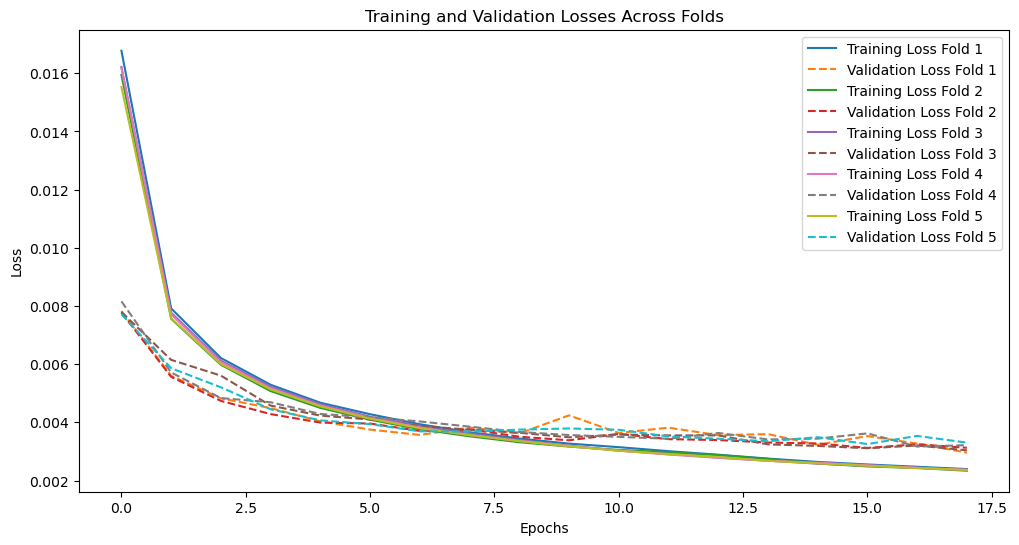

In [35]:
# Perform K-Fold Cross-Validation and get the best autoencoder model
best_autoencoder = perform_k_fold_cross_validation(train_val_paths, k=5)

In [36]:
best_autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 128, 128, 96)         2688      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_6 (Bat  (None, 128, 128, 96)         384       ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 96)           0         ['batch_normalization_6[

In [37]:
# Define the encoder model using the best autoencoder model
encoder = tf.keras.models.Model(inputs=best_autoencoder.input, outputs=best_autoencoder.get_layer('bottleneck').output)

In [38]:
best_autoencoder.save('/Users/ximenamoure/Desktop/drift_last/split5_training_autoencoder_v3/autoencoder_model.h5')

/Users/ximenamoure/tensorflow-test/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
# Calculate and store the baseline reconstruction error
baseline_losses = []
for batch in train_dataset:
    # Assuming train_dataset yields tuples (input, target)
    input_images, _ = batch  # Ignore the labels if any
    preds = best_autoencoder.predict(input_images)
    loss = mean_squared_error(input_images.numpy().flatten(), preds.flatten())
    baseline_losses.append(loss)

baseline_loss = np.mean(baseline_losses)

with open('/Users/ximenamoure/Desktop/drift_last/split5_training_autoencoder_v3/baseline_loss.pkl', 'wb') as f:
    pickle.dump(baseline_loss, f)

2024-08-29 15:15:19.503668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 100ms/step


2024-08-29 15:17:12.151063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 335ms/step


In [41]:
# Evaluate the final model on the separate test set
test_loss = best_autoencoder.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')

151/151 [==============================] - 13s 88ms/step - loss: 0.0030
Test Loss: 0.0030243019573390484


In [39]:

encoder.save('/Users/ximenamoure/Desktop/drift_last/split5_training_autoencoder_v3/encoder_model.h5')

In [42]:
combined_dataset = train_dataset.concatenate(val_dataset)

1/1 [==============================] - 0s 171ms/step


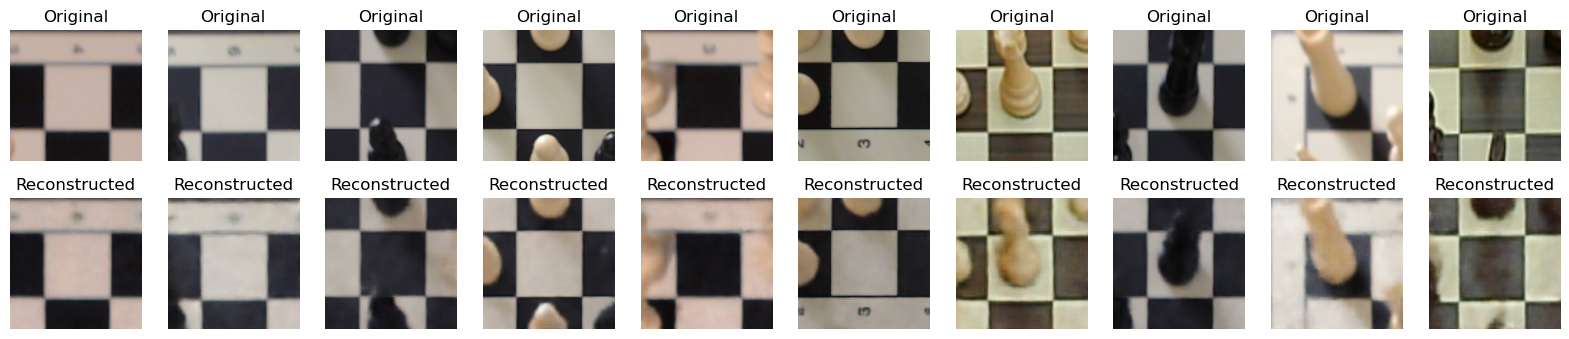

In [43]:
def plot_reconstructions(model, dataset, n=10):
    # Get a batch of images from the dataset
    batch = next(iter(dataset))
    images = batch[0][:n]  # Get the first n images

    # Get the reconstructed images
    reconstructed_images = model.predict(images)

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i].numpy())
        plt.title("Original")
        plt.axis("off")

        # Reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_images[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

# Plot the original and reconstructed images
plot_reconstructions(best_autoencoder, combined_dataset)


1/1 [==============================] - 0s 337ms/step


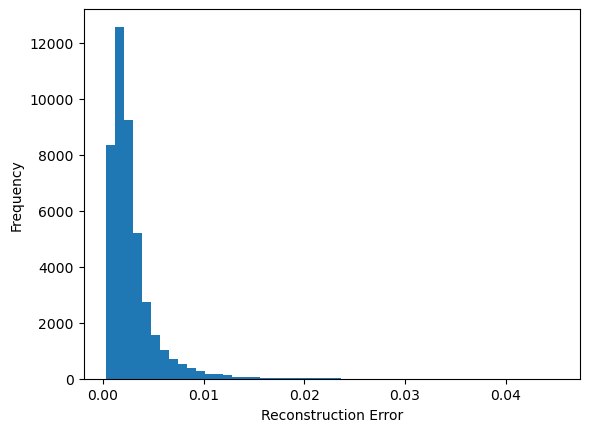

In [44]:
# Function to calculate reconstruction error
def calculate_reconstruction_error(model, dataset):
    errors = []
    for batch in dataset:
        images = batch[0]
        reconstructed_images = model.predict(images)
        mse = np.mean(np.square(images.numpy() - reconstructed_images), axis=(1, 2, 3))
        errors.extend(mse)
    return np.array(errors)

# Calculate reconstruction error for the baseline dataset
reconstruction_errors = calculate_reconstruction_error(best_autoencoder, combined_dataset)

# Plot the reconstruction error
plt.hist(reconstruction_errors, bins=50)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()


In [47]:
# Identify high error samples
high_error_threshold = np.percentile(reconstruction_errors, 95)  # Top 5% highest errors
high_error_indices = np.where(reconstruction_errors > high_error_threshold)[0]

print(f"Number of high error samples: {len(high_error_indices)}")

Number of high error samples: 2171


In [48]:
# Function to extract high error images from the dataset
def extract_high_error_images(dataset, high_error_indices, n=10):
    high_error_images = []
    counter = 0

    for batch in dataset:
        images = batch[0].numpy()
        for idx in high_error_indices:
            if counter < n and idx < images.shape[0]:
                high_error_images.append(images[idx])
                counter += 1
        if counter >= n:
            break

    return np.array(high_error_images)


In [49]:
# Extract high error images
high_error_images = extract_high_error_images(combined_dataset, high_error_indices, n=10)

# Ensure high_error_images has the correct shape
high_error_images = high_error_images.reshape(-1, 128, 128, 3)

# Get the reconstructed images
reconstructed_images = best_autoencoder.predict(high_error_images)


1/1 [==============================] - 0s 122ms/step


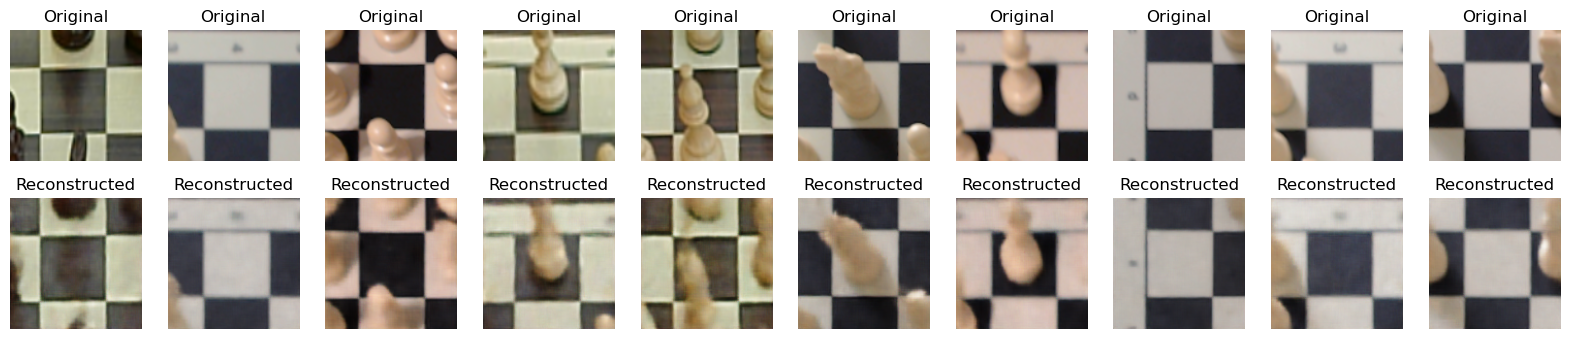

In [50]:
# Plot original and reconstructed images
def plot_images(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        plt.title("Original")
        plt.axis("off")

        # Reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()


# Plot the high error samples
plot_images(high_error_images, reconstructed_images)


In [51]:
encoder.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 128, 128, 96)         2688      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_6 (Bat  (None, 128, 128, 96)         384       ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 96)           0         ['batch_normalization_6[

In [52]:
# Function to extract features (latent space representations) from the dataset
def extract_latent_space(dataset, encoder):
    latent_space = []
    for batch in dataset:
        images = batch[0]
        encoded_batch = encoder.predict(images)
        latent_space.append(encoded_batch)
    latent_space = np.concatenate(latent_space, axis=0)
    return latent_space

# Extract features from the full dataset
latent_space = extract_latent_space(combined_dataset, encoder)

print("Latent space shape:", latent_space.shape)

1/1 [==============================] - 0s 13ms/step


2024-08-29 15:21:46.897299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 10ms/step


2024-08-29 15:22:27.763372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 97ms/step
Latent space shape: (43408, 100)


In [53]:
print("Latent space shape:", latent_space.shape)
print("Contains NaN:", np.isnan(latent_space).any())
print("Contains infinite:", np.isinf(latent_space).any())


Latent space shape: (43408, 100)
Contains NaN: False
Contains infinite: False


In [54]:
from sklearn.manifold import TSNE
import seaborn as sns

   4/1357 [..............................] - ETA: 27s 

2024-08-29 15:24:22.017004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1357/1357 [==============================] - 21s 15ms/step


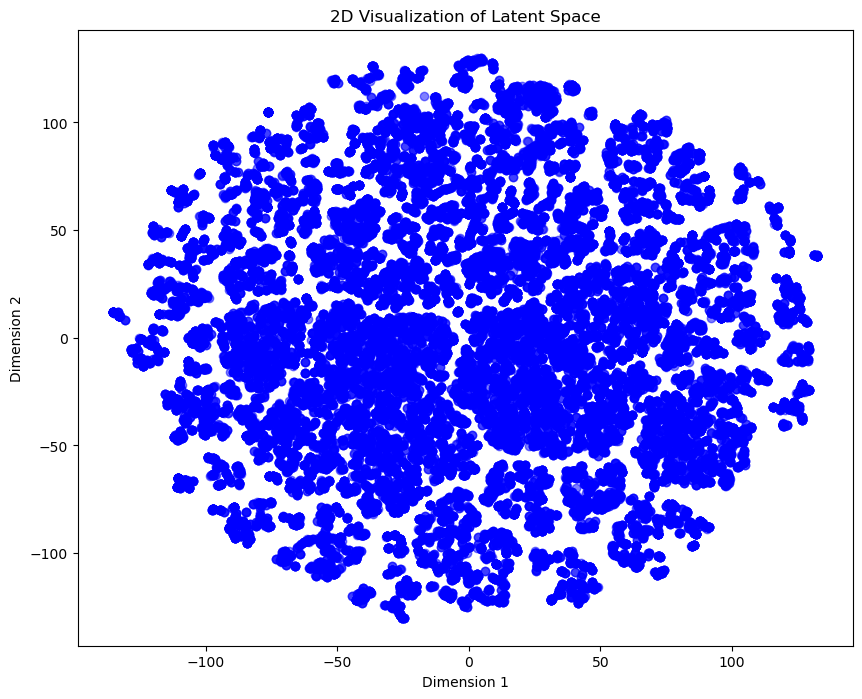

In [55]:
# Encode the data
encoded_data = encoder.predict(combined_dataset)

# Use t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2)
encoded_data_2d = tsne.fit_transform(encoded_data)

# Plot the encoded data
# Plot the encoded data without labels
plt.figure(figsize=(10, 8))
plt.scatter(encoded_data_2d[:, 0], encoded_data_2d[:, 1], c='blue', alpha=0.5)
plt.title("2D Visualization of Latent Space")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [56]:
combined_labels = np.concatenate([train_labels, val_labels], axis=0)

1357/1357 [==============================] - 21s 16ms/step


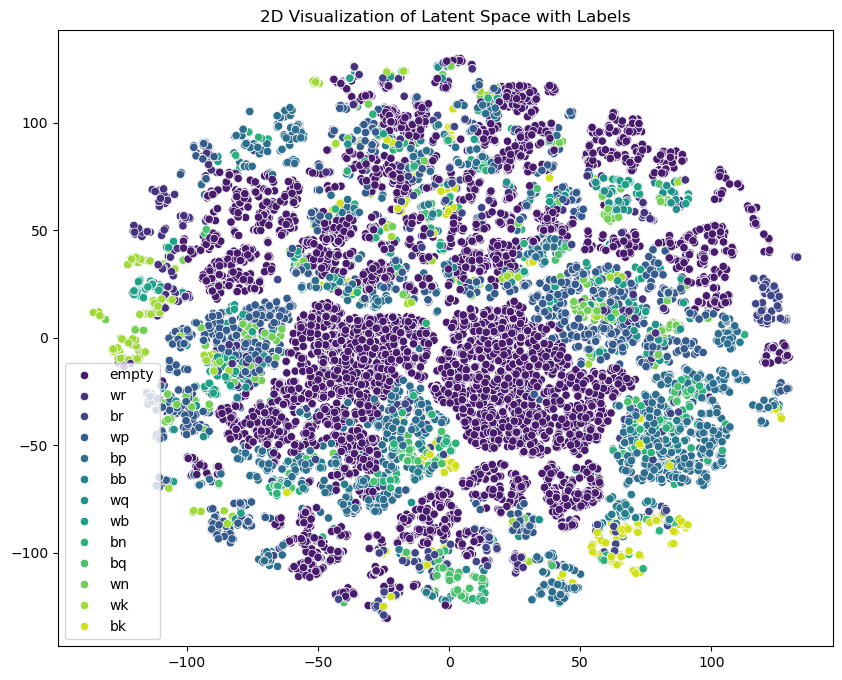

In [57]:
# Encode the data
encoded_data = encoder.predict(combined_dataset)

# Use t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2)
encoded_data_2d = tsne.fit_transform(encoded_data)


plt.figure(figsize=(10, 8))
sns.scatterplot(x=encoded_data_2d[:, 0], y=encoded_data_2d[:, 1], hue=combined_labels, palette="viridis", legend='full')
plt.title("2D Visualization of Latent Space with Labels")
plt.show()

In [58]:
# Extract one batch of images from the combined dataset (train + val)
sample_batch = next(iter(combined_dataset))

# Extract one image from the batch
sample_image = sample_batch[0][0]  # First image in the batch



2024-08-29 15:28:49.470352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


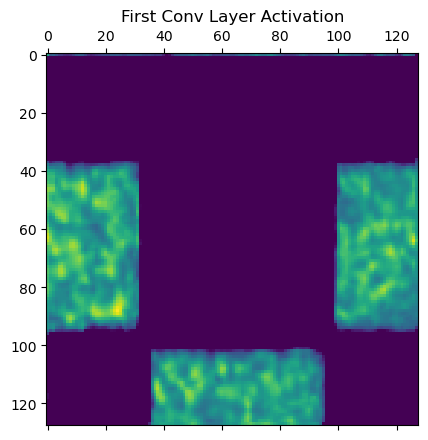

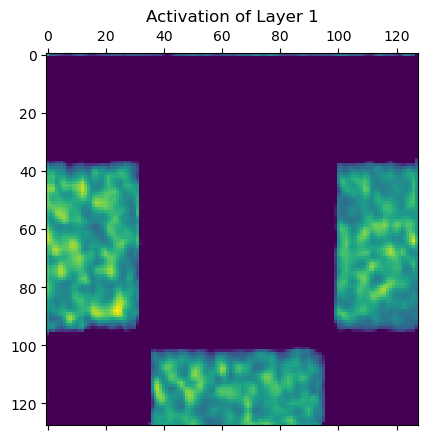

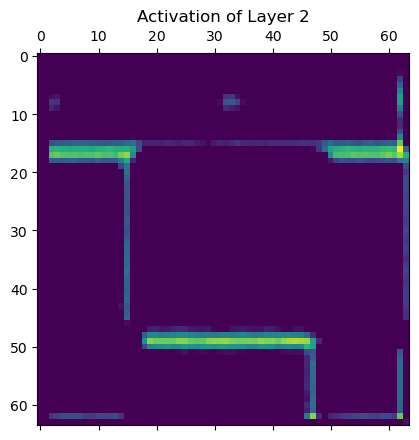

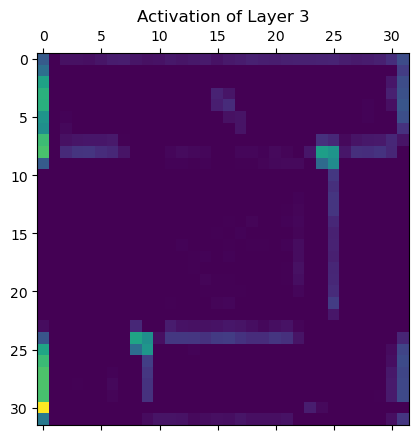

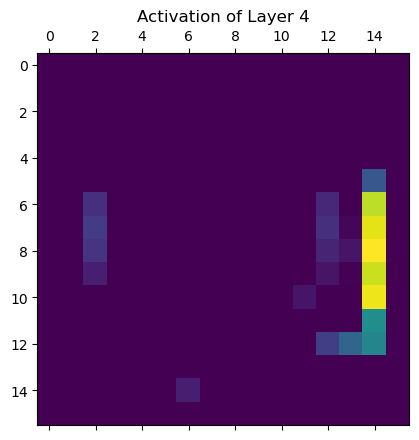

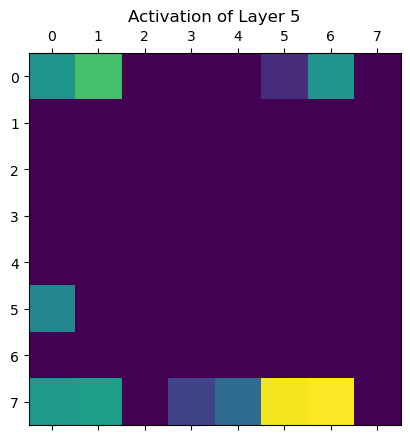

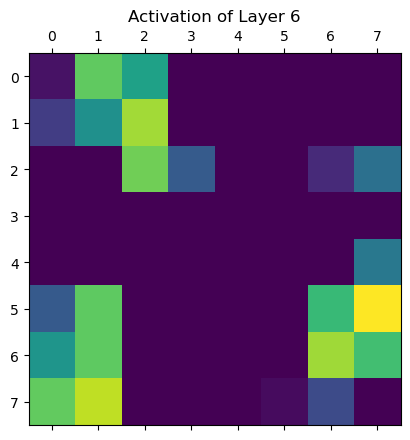

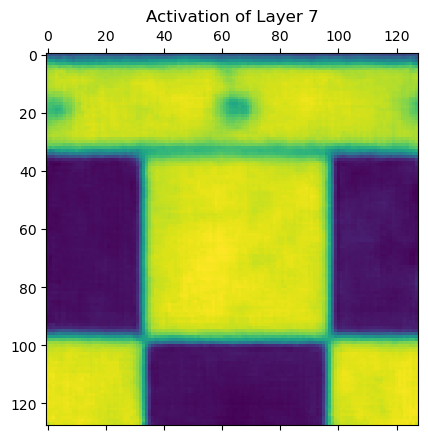

In [59]:
import matplotlib.pyplot as plt
from tensorflow.keras import models

# Ensure the image has the correct shape, adding batch dimension if necessary
sample_image = tf.expand_dims(sample_image, axis=0)

# Extract outputs from the convolutional layers you want to visualize
layer_outputs = [
    best_autoencoder.get_layer('conv2d_7').output,
    best_autoencoder.get_layer('conv2d_8').output,
    best_autoencoder.get_layer('conv2d_9').output,
    best_autoencoder.get_layer('conv2d_10').output,
    best_autoencoder.get_layer('conv2d_11').output,
    best_autoencoder.get_layer('conv2d_12').output,
    best_autoencoder.get_layer('conv2d_13').output

]

# Create a model that returns the outputs of the specified layers
activation_model = models.Model(inputs=best_autoencoder.input, outputs=layer_outputs)

# Get the activations for the sample image
activations = activation_model.predict(sample_image)

# Visualize the activations of the first convolutional layer
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')
plt.title("First Conv Layer Activation")
plt.show()

# Visualize activations for additional layers
for i, activation in enumerate(activations):
    plt.matshow(activation[0, :, :, 0], cmap='viridis')
    plt.title(f"Activation of Layer {i+1}")
    plt.show()



1/1 [==============================] - 0s 68ms/step


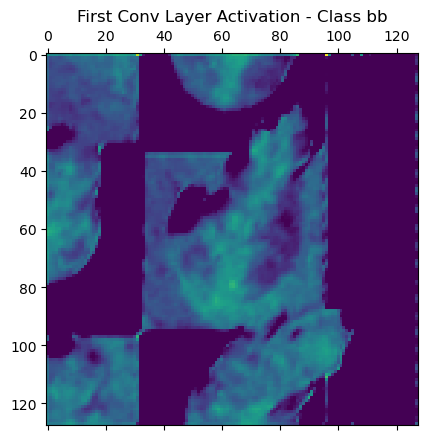

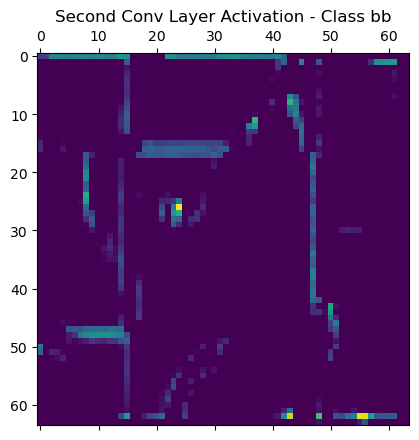

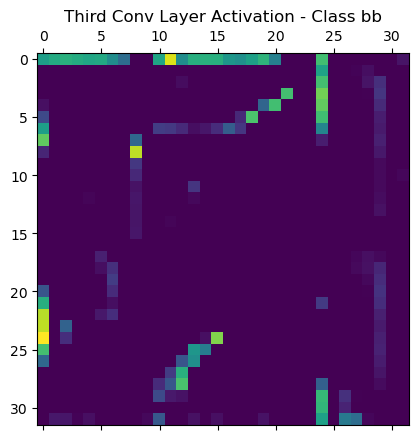

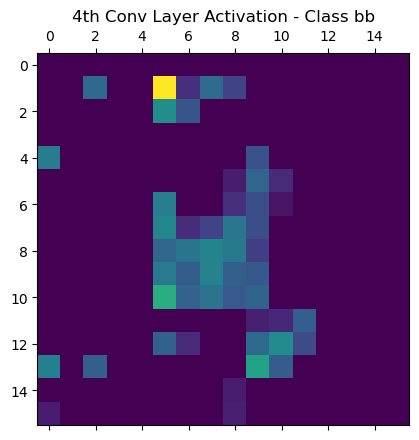

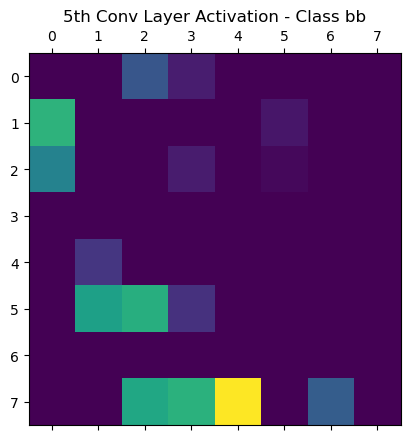

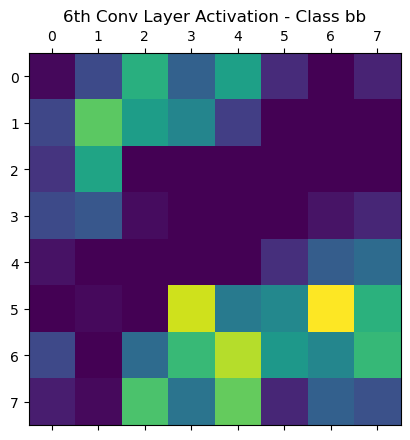

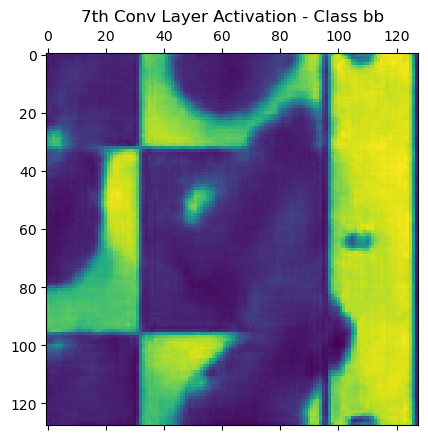

1/1 [==============================] - 0s 20ms/step


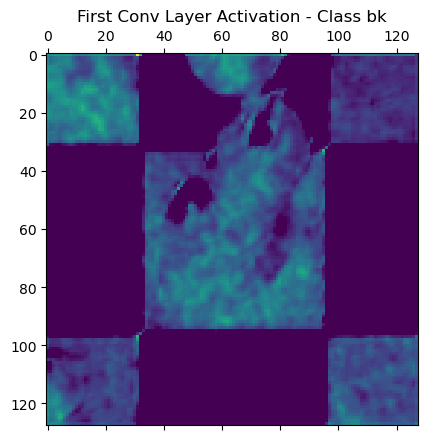

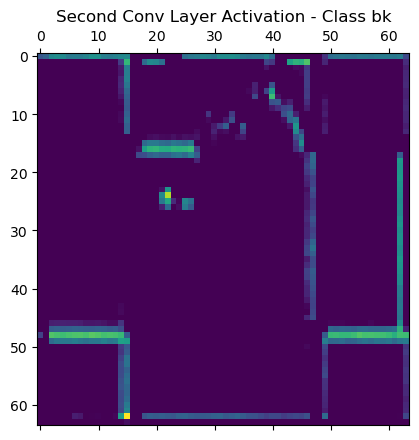

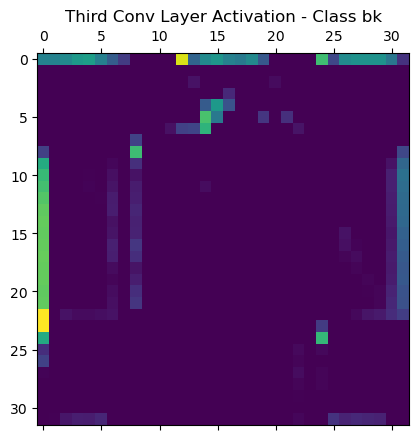

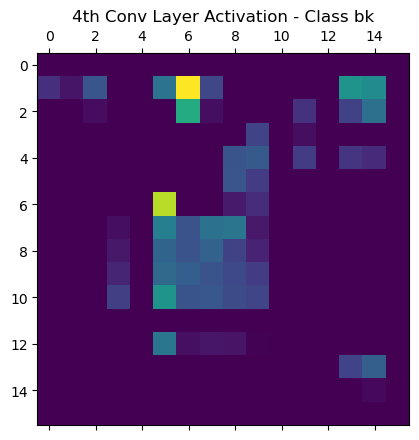

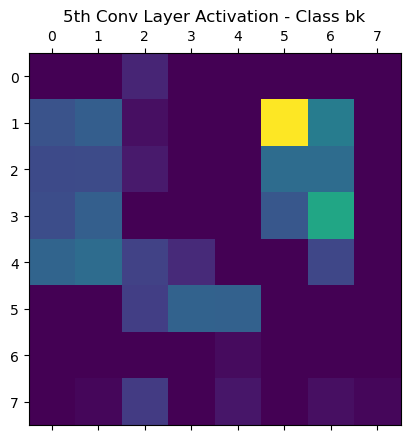

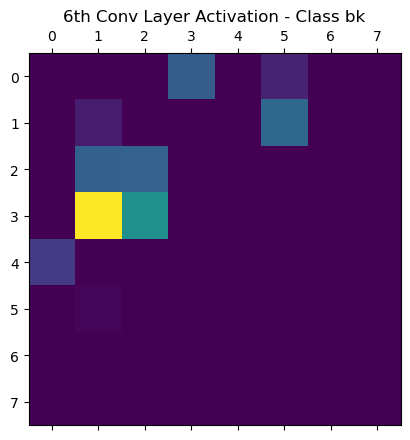

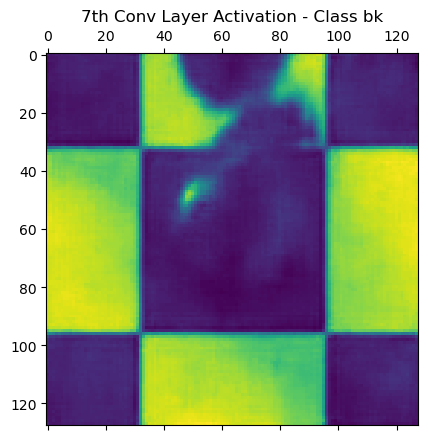

1/1 [==============================] - 0s 25ms/step


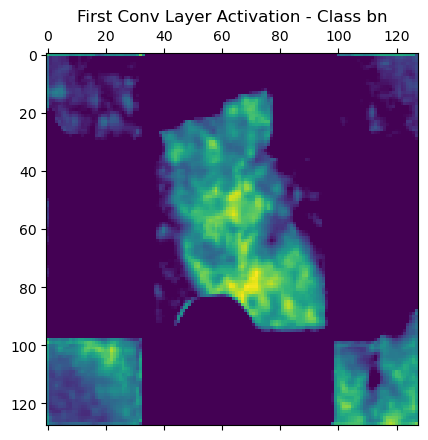

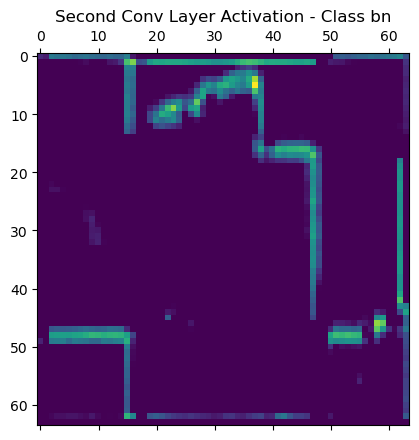

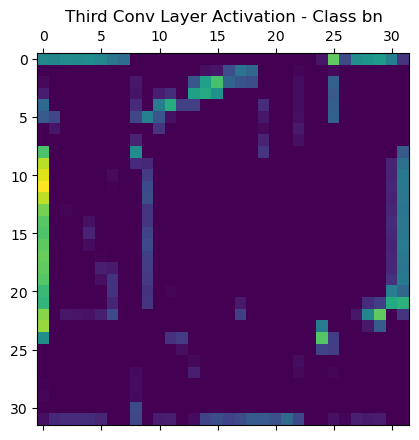

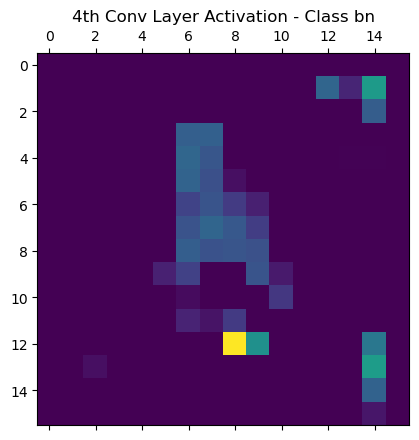

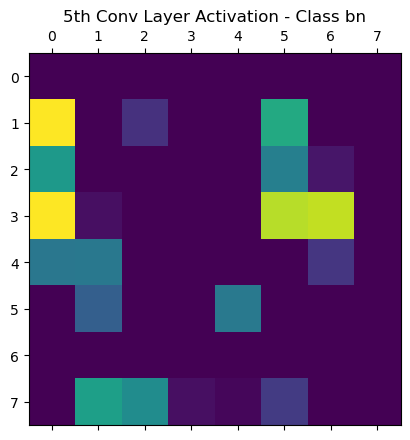

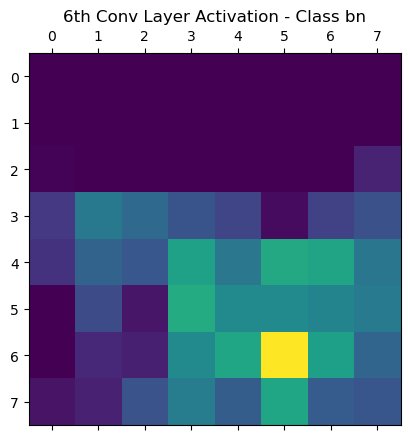

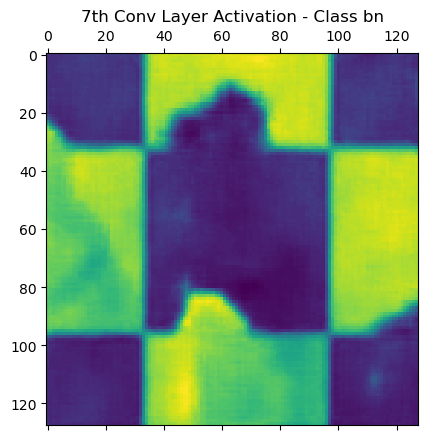

In [60]:
# Iterate through images from different classes
for class_name in ['bb', 'bk', 'bn']:  # Add more classes as needed
    # Find one image from each class
    class_image_path = [path for path in train_paths if class_name in path][0]
    class_image = load_image(class_image_path)

    # Expand dimensions to match model input
    class_image = tf.expand_dims(class_image, axis=0)

    # Get activations
    activations = activation_model.predict(class_image)

    # Visualize activations
    first_layer_activation = activations[0]
    plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')
    plt.title(f"First Conv Layer Activation - Class {class_name}")
    plt.show()


    # Visualize activations
    first_layer_activation = activations[1]
    plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')
    plt.title(f"Second Conv Layer Activation - Class {class_name}")
    plt.show()


     # Visualize activations
    first_layer_activation = activations[2]
    plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')
    plt.title(f"Third Conv Layer Activation - Class {class_name}")
    plt.show()


     # Visualize activations
    first_layer_activation = activations[3]
    plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')
    plt.title(f"4th Conv Layer Activation - Class {class_name}")
    plt.show()

    first_layer_activation = activations[4]
    plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')
    plt.title(f"5th Conv Layer Activation - Class {class_name}")
    plt.show()

    first_layer_activation = activations[5]
    plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')
    plt.title(f"6th Conv Layer Activation - Class {class_name}")
    plt.show()

    first_layer_activation = activations[6]
    plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')
    plt.title(f"7th Conv Layer Activation - Class {class_name}")
    plt.show()

/Users/ximenamoure/tensorflow-test/env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/ximenamoure/tensorflow-test/env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


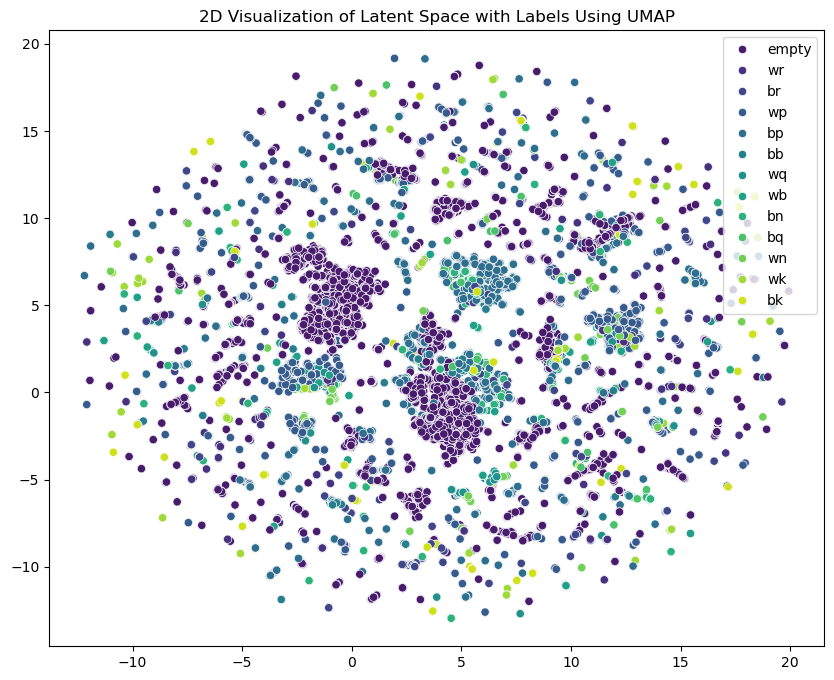

In [61]:
# Apply UMAP for dimensionality reduction to 2D
umap_model = umap.UMAP(n_components=2, random_state=42)
encoded_data_2d = umap_model.fit_transform(encoded_data)

# Plot the encoded data with hue based on the combined labels using Seaborn's scatterplot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=encoded_data_2d[:, 0], y=encoded_data_2d[:, 1], hue=combined_labels, palette="viridis", legend='full')
plt.title("2D Visualization of Latent Space with Labels Using UMAP")
plt.show()